# House Prices v2 - Advanced Regression Techniques 

#### Import Libraries

In [193]:
# Standard Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to fill missing values
from sklearn.impute import SimpleImputer

# EDA/ Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold

# Statistics functions
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Separating data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score,r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#### Reading Data

In [2]:
# Read data and test sets
train = pd.read_csv('/Users/cheongkyler/Documents/Y2S2 Summer/DSA Project 1 (House Prices)/train.csv')
test = pd.read_csv('/Users/cheongkyler/Documents/Y2S2 Summer/DSA Project 1 (House Prices)/test.csv')

#### Settings

In [3]:
# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

Checking shape and information of train and test data.

In [4]:
# Shape
print(f"Shape of train data (raw) : {train.shape}\n")
print(f"Shape of test data (raw) : {test.shape}\n")

Shape of train data (raw) : (1460, 81)

Shape of test data (raw) : (1459, 80)



Check difference in test and train data columns

In [5]:
diff_1 = [col for col in train.columns if col not in test.columns]
print(f"Columns present in train but not in test : {diff_1}\n")

diff_2 = [col for col in test.columns if col not in train.columns]
print(f"Columns present in test but not in train : {diff_2}\n")

Columns present in train but not in test : ['SalePrice']

Columns present in test but not in train : []



Drop ['Id'] in train dataset, keep ['Id'] in test dataset (submission purposes)

In [6]:
# Drop ['Id']
train.drop(['Id'], axis = 'columns', inplace = True)

# Keep ['Id']
test_id = list(test['Id'])
test.drop(['Id'], axis = 'columns', inplace = True)

In [7]:
# Shape
print(f"Shape of train data (raw) : {train.shape}\n")
print(f"Shape of test data (raw) : {test.shape}\n")

Shape of train data (raw) : (1460, 80)

Shape of test data (raw) : (1459, 79)



Split data into categorical and numerical features.

In [8]:
# Split for test and train datasets
numerical_cols = ['int64', 'float64']
non_numerical_cols = ['object']

train_num = train.select_dtypes(include = numerical_cols)
test_num = test.select_dtypes(include = numerical_cols)

print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

train_cat = train.select_dtypes(include = non_numerical_cols)
test_cat = test.select_dtypes(include = non_numerical_cols)

print(f"Shape of train data (cat) : {train_cat.shape}\n")
print(f"Shape of test data (cat) : {test_cat.shape}\n")

Shape of train data (num) : (1460, 37)

Shape of test data (num) : (1459, 36)

Shape of train data (cat) : (1460, 43)

Shape of test data (cat) : (1459, 43)



# Numerical Features

Steps to deal with Numerical Features:
1. Check distribution for all features, remove quasi-constant features.
2. Check correlation matrix, remove features with low collinearity with 'SalePrice' |r| < 0.3
3. Check for multi-collinearity, remove co-dependent features.
4. Check for percentage of missing values, remove those with more than 30% of missing values
4. Impute missing values with median/ mean.
5. Check for difference in distribution before and after imputation, if significant difference, drop the feature.
6. Make sure to do for test and train datasets!

Correction. Steps should be done in this order 1 -> 2 -> 4 -> 5 -> 3 -> 6.

Because step 3, the calculation of VIF requires no missing values in the dataset

#### Check for distribution for features

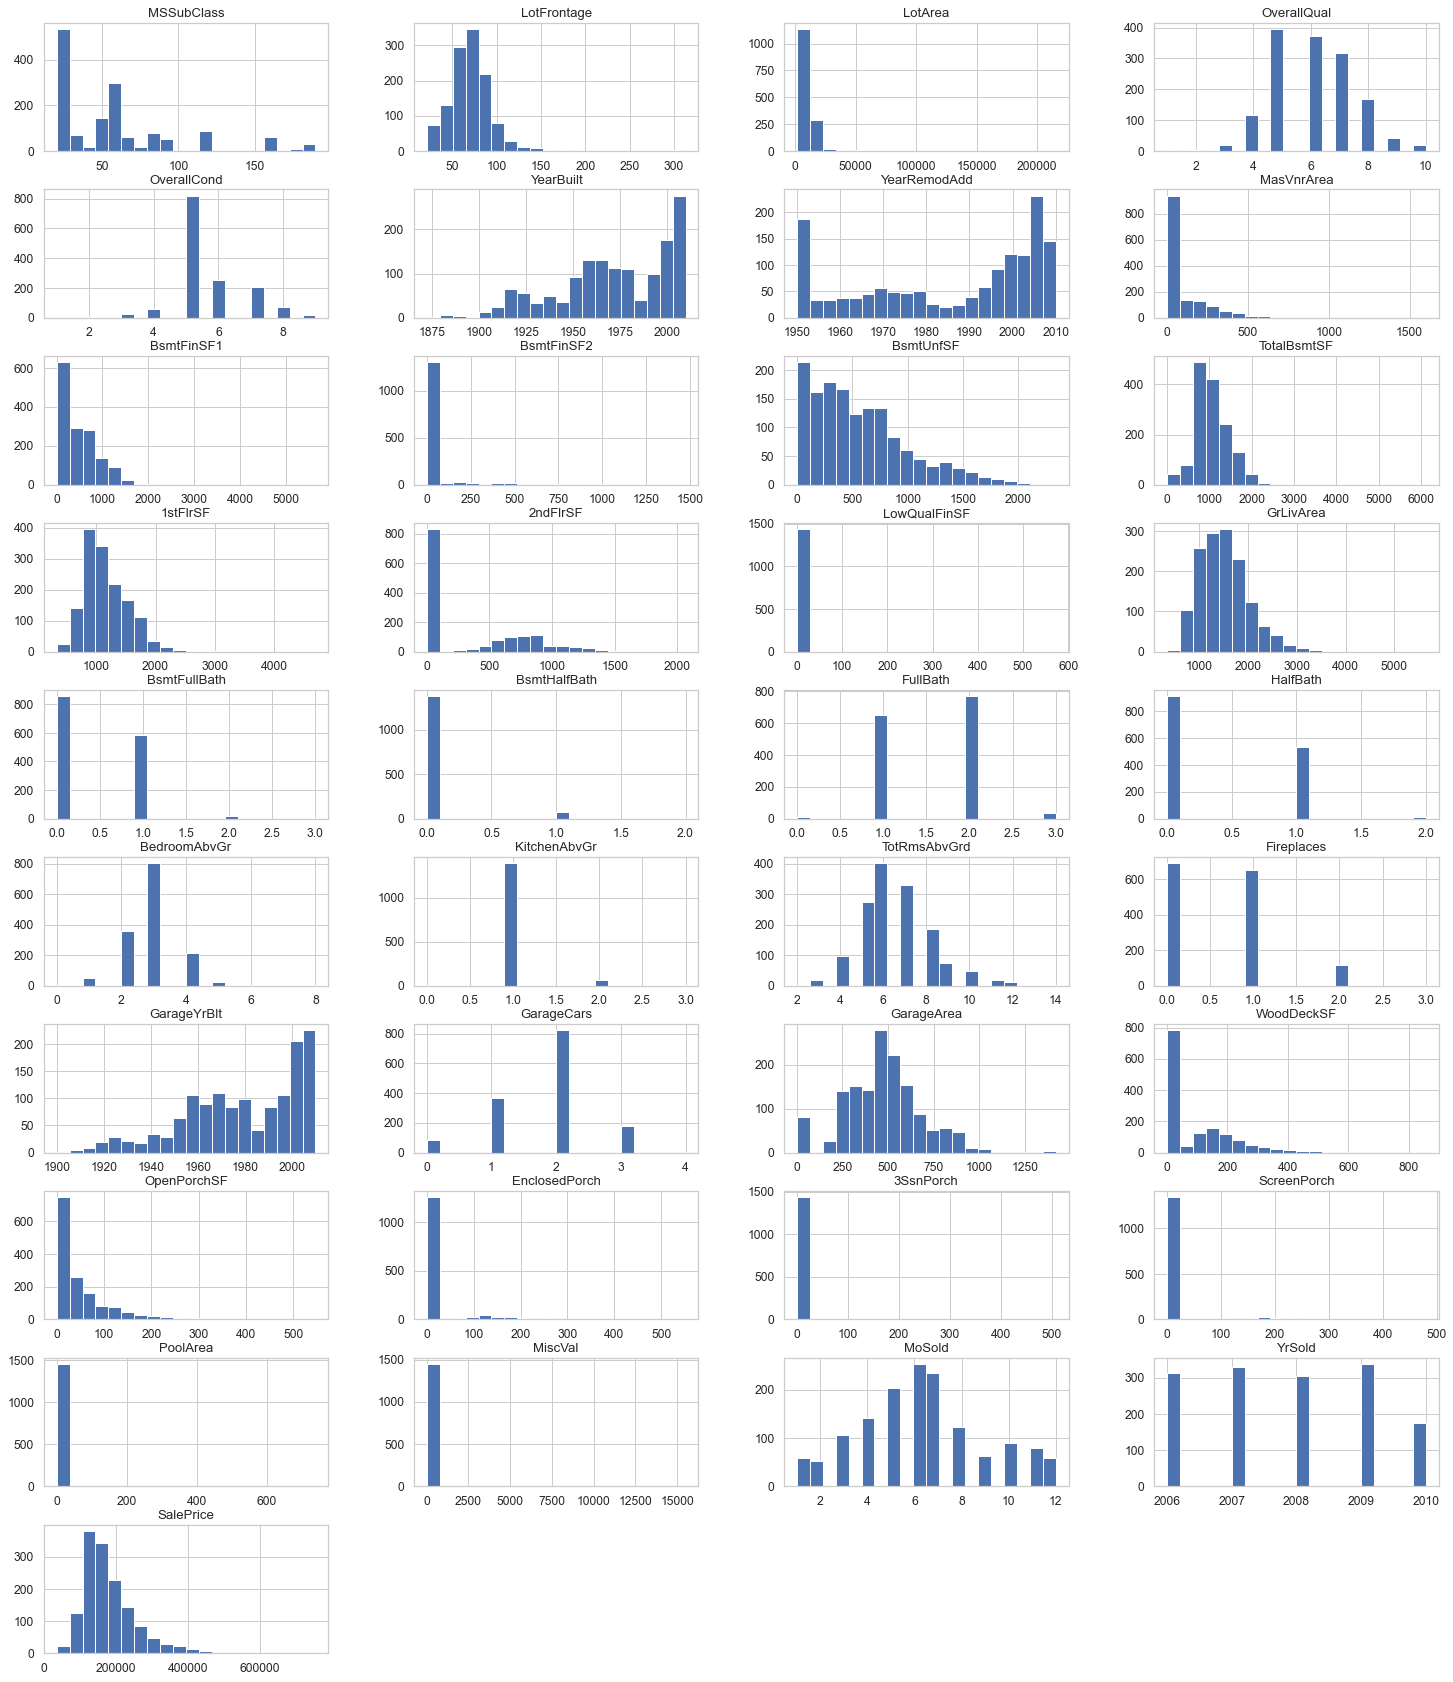

In [9]:
# Check distribution using histograms
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
train_num.hist(bins=20, figsize=(25, 30), layout=(10, 4));

Looking at all the distribution, we can see a mixture of discrete and continuous variables, for example 'GarageCars' is discrete, while 'OpenPorchSF' is continuous. We now want to remove features which have a variance of less than 5%. i.e removing quasi-constant features with threshold 95%.

#### Variance Threshold Notes
- remove redundant features, shrink training times, reduce chances of overfitting and improving predictions.
- Works only on numerical features.
- variance can be seriously affected by scale of features, hence need apply feature scaling.
- useful after OHE categorical features, when they have very low variances.

In [10]:
# removing quasi-constant features
vt = VarianceThreshold(threshold = 0.05)
print(f"No. of cols retained :{vt.fit_transform(train_num.iloc[:, :-1]).shape[1]}\n") # shows number of columns retained
print(f"No. of cols to be removed : {len(train_num.iloc[:, :-1].columns) - vt.get_support().sum()}\n")

# feature to be removed
q_const_features = [col for col in train_num.iloc[:,:-1].columns if col not in train_num.iloc[:, :-1].columns[vt.get_support()]]
print(f"Quasi-constant features : {q_const_features}\n")


No. of cols retained :35

No. of cols to be removed : 1

Quasi-constant features : ['KitchenAbvGr']



In [11]:
# Drop ['KitchenAbvGr'] from train and test dataset
train_num.drop(['KitchenAbvGr'], axis = 'columns', inplace = True)
test_num.drop(['KitchenAbvGr'], axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
# Shape
print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

Shape of train data (num) : (1460, 36)

Shape of test data (num) : (1459, 35)



#### Check correlation matrix

In [13]:
def editCorrMat(v, n, m): # v: value of entry in concern, n: new value to reset to, m: corr. matrix
    m[abs(m) < v] = n
    return m

In [14]:
# Set values |r| < 0.3 to 0
corr = editCorrMat(0.3, 0, train_num.corr())

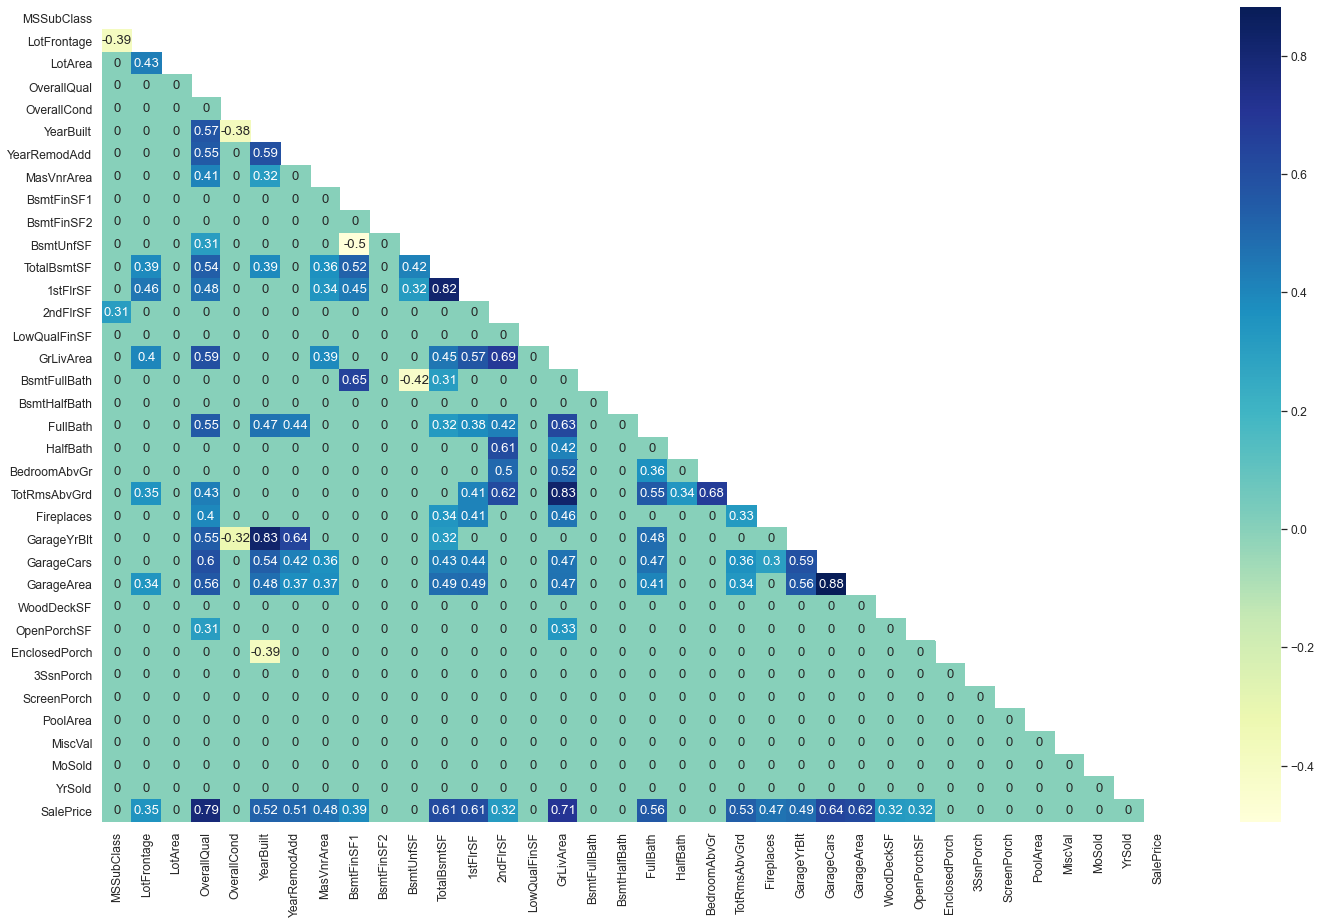

In [15]:
# Plot correlation matrix, set |r| < 0.3 to 0 for readability
fig, ax1 = plt.subplots(figsize=(24,15))


mask = np.triu(np.ones_like(corr, dtype=bool)) # generate mask to prevent upper triangular matrix to be plotted
heatmap = sns.heatmap(corr, mask = mask, cmap="YlGnBu", annot=True)

In [16]:
features_removed = ['MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath',
                   'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                   'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [17]:
# Drop features in test and train datasets with low correlation
train_num.drop(columns = features_removed, axis = 'columns', inplace = True)
test_num.drop(columns = features_removed, axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
# Shape
print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

Shape of train data (num) : (1460, 19)

Shape of test data (num) : (1459, 18)



Cols with missing values : ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']



Text(0.5, 1.0, 'Percent NA')

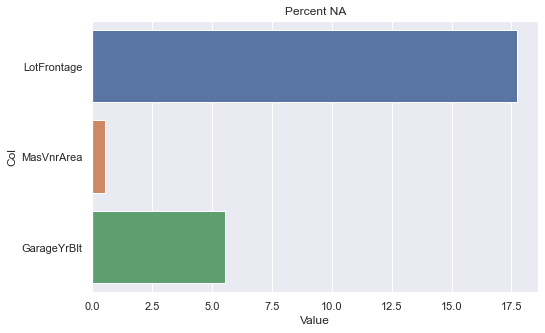

In [19]:
# Check for percentage of missing values in train set, remove those > 30% missing values, remove for test set
cols_missing_values_train = [col for col in train_num.columns if train_num[col].isna().sum() > 0]
print(f"Cols with missing values : {cols_missing_values_train}\n")

# Values of missing entries
value_missing_cols_train = list(map(lambda x: (train_num[x].isna().sum()/len(train_num)) * 100, cols_missing_values_train))

percentNA_df = pd.DataFrame(list(zip(cols_missing_values_train, value_missing_cols_train)), columns = ['Col', 'Value'])

# Plot barplot
sns.set(rc = {'figure.figsize':(8,5)})
sns.barplot(x = percentNA_df['Value'], y = percentNA_df['Col'], data = percentNA_df).set_title("Percent NA")

In [20]:
# SimpleImputer
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

In [21]:
# decide if use mean or median to impute, using distribution from prev plot
# use median for all
train_num_imputed = pd.DataFrame(imp_median.fit_transform(train_num))

# Note: train_num_imputed is a df that contains the exact same values at train_num, except, the missing values
#       imputed as median. use .head() to check what i mean

# Set the columns of train_num_imputed as train_num
train_num_imputed.columns = train_num.columns

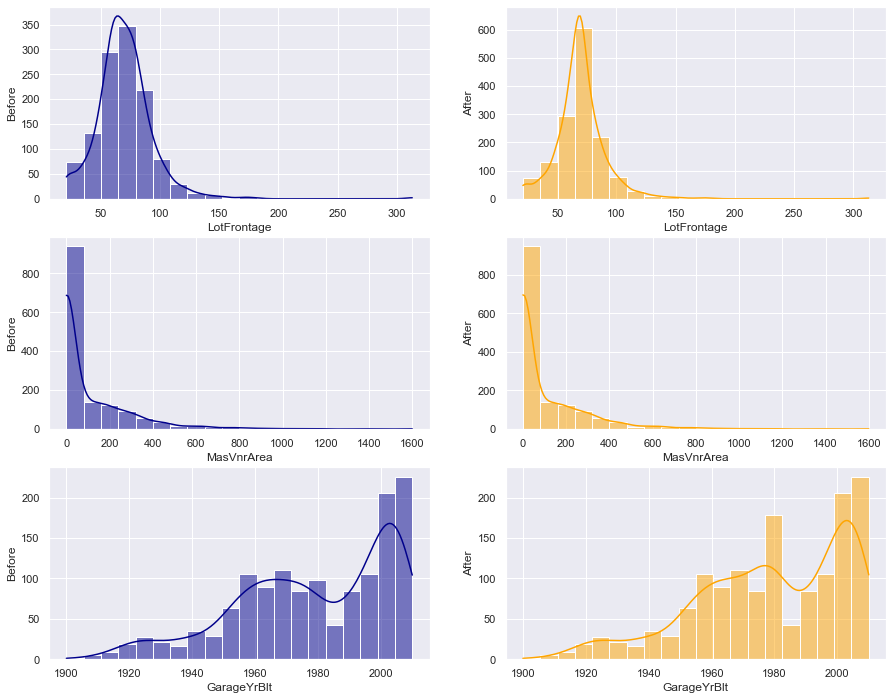

In [22]:
# Check distribution for before and after imputing the missing values
sns.set(rc = {'figure.figsize':(15,12)})
fig, axes = plt.subplots(3, 2) # fig is the empty grid, axes is the array object of axes

rowNum = 0
for col in cols_missing_values_train:
    sns.histplot(x = train_num[col], kde = True, ax = axes[rowNum, 0], color = "darkblue", bins = 20).set_ylabel("Before")
    rowNum += 1
    
rowNum = 0
for col in cols_missing_values_train:
    sns.histplot(x = train_num_imputed[col], kde = True, ax = axes[rowNum, 1], color = "orange", bins = 20).set_ylabel("After")
    rowNum += 1

Numercial variables, 'LotFrontage' and 'GarageYrBlt' have a significant change in difference in distribution when imputed with the median. Hence, we now try to impute it with the median instead. 'MasVnrArea' can be kept.

In [23]:
# .fit_transform returns a dataframe diff from train_num, all values same except imputed with mean, check .head()
# if unclear of what i mean.
train_imputed_mean = pd.DataFrame(imp_mean.fit_transform(train_num))

train_imputed_mean.columns = train_num.columns

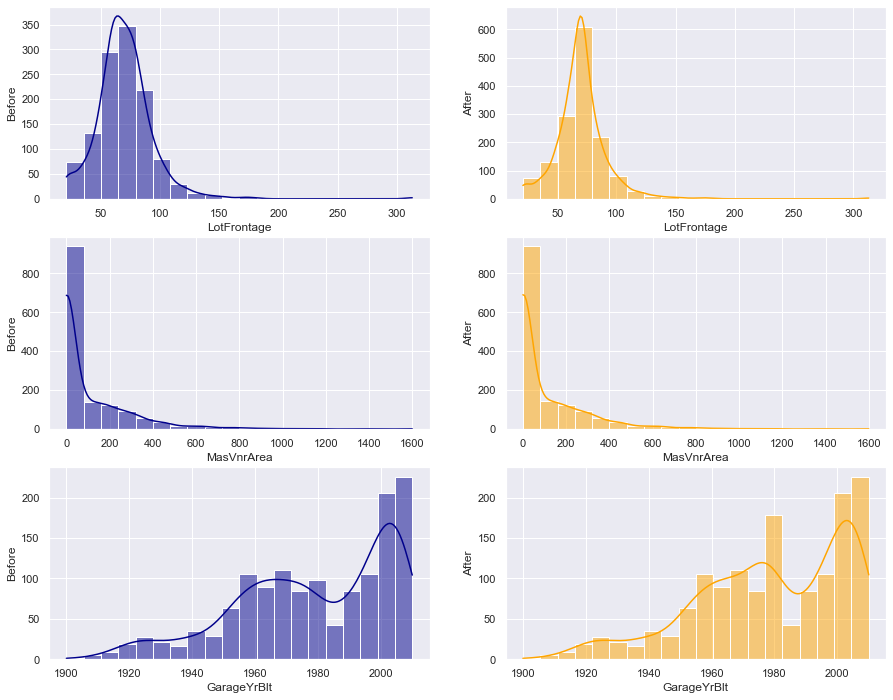

In [24]:
# Check distribution before and after
sns.set(rc = {'figure.figsize':(15,12)})
fig, axes = plt.subplots(3, 2) # fig is the empty grid, axes is the array object of axes

rowNum = 0
for col in cols_missing_values_train:
    sns.histplot(x = train_num[col], kde = True, ax = axes[rowNum, 0], color = "darkblue", bins = 20).set_ylabel("Before")
    rowNum += 1
    
rowNum = 0
for col in cols_missing_values_train:
    sns.histplot(x = train_imputed_mean[col], kde = True, ax = axes[rowNum, 1], color = "orange", bins = 20).set_ylabel("After")
    rowNum += 1

After imputing with mean, the distribution of 'LotFrontage' and 'GarageYrBlt' still differs significantly. Hence, I will drop these columns.

In [25]:
# Drop 'LotFrontage' and 'GarageYrBlt' from test and train dataset.
train_num.drop(columns = ['LotFrontage', 'GarageYrBlt'], axis = 'columns', inplace = True)

test_num.drop(columns = ['LotFrontage', 'GarageYrBlt'], axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
train_num['MasVnrArea'] = train_num_imputed['MasVnrArea']

<ipython-input-26-87baa9841489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num['MasVnrArea'] = train_num_imputed['MasVnrArea']


In [27]:
train_num.isna().sum().sum()

0

In [28]:
# Check shape
# Shape
print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

Shape of train data (num) : (1460, 17)

Shape of test data (num) : (1459, 16)



Text(0.5, 1.0, 'Percent NA (Test))')

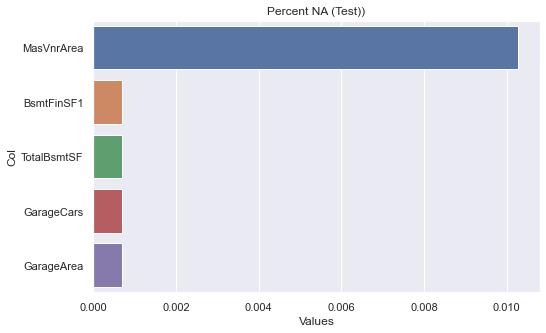

In [29]:
# Check for percentage of missing values in test set
cols_w_NA_test = [col for col in test_num.columns if test_num[col].isna().sum() > 0]

# Find values (% of missing values in each of the columns)
values_NA_test = list(map(lambda x: test_num[x].isna().sum() / len(test_num), cols_w_NA_test))

# Plot (% of missing values)
percentNA_df_test = pd.DataFrame(list(zip(cols_w_NA_test, values_NA_test)), columns = ['Col', 'Values'])

# Plot barplot
sns.set(rc = {'figure.figsize':(8,5)})
sns.barplot(x = percentNA_df_test['Values'], y = percentNA_df_test['Col'], data = percentNA_df_test).set_title("Percent NA (Test))")

Very small percentage of NA values only. Hence, impute with median and compare before and after.

In [30]:
# Impute with median
# .fit_transform returns a dataframe diff from train_num, all values same except imputed with mean, check .head()
# if unclear of what i mean.
test_num_imputed = pd.DataFrame(imp_median.fit_transform(test_num))

test_num_imputed.columns = test_num.columns

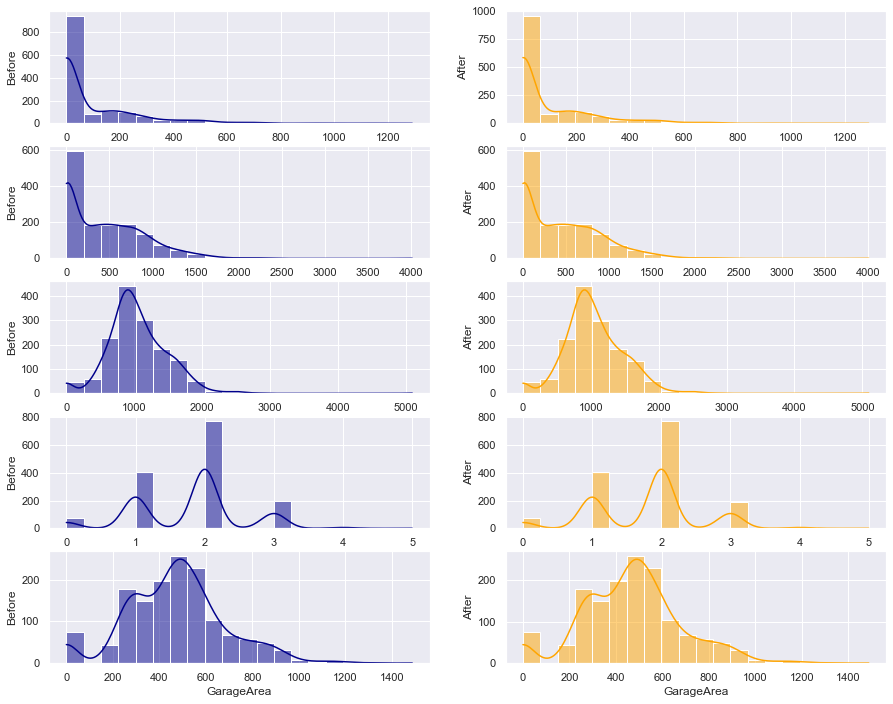

In [31]:
# Check distribution for before and after imputing the missing values
sns.set(rc = {'figure.figsize':(15,12)})
fig, axes = plt.subplots(5, 2) # fig is the empty grid, axes is the array object of axes

rowNum = 0
for col in cols_w_NA_test:
    sns.histplot(x = test_num[col], kde = True, ax = axes[rowNum, 0], color = "darkblue", bins = 20).set_ylabel("Before")
    rowNum += 1
    
rowNum = 0
for col in cols_w_NA_test:
    sns.histplot(x = test_num_imputed[col], kde = True, ax = axes[rowNum, 1], color = "orange", bins = 20).set_ylabel("After")
    rowNum += 1

All imputed missing values did not differ from the original distribution and hence will keep these imputed columns.

In [32]:
# Set test_num to be test_num_imputed
test_num = test_num_imputed

In [33]:
# Check shape
# Shape
print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

Shape of train data (num) : (1460, 17)

Shape of test data (num) : (1459, 16)



#### Check for multicollinearity

In [34]:
# extract features
poss_pred = train_num.columns.tolist()[:-1]

In [35]:
# VIF function
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [36]:
calculate_vif(df = train_num.iloc[:, :-1], features = poss_pred)

,VIF,Tolerance
OverallQual,2.881536,0.347037
YearBuilt,2.482971,0.402743
YearRemodAdd,1.808689,0.552887
MasVnrArea,1.355377,0.737802
BsmtFinSF1,1.535302,0.651338
TotalBsmtSF,3.913943,0.255497
1stFlrSF,71.365953,0.014012
2ndFlrSF,88.060531,0.011356
GrLivArea,126.067425,0.007932
FullBath,2.294462,0.435832


VIF ranked:
'GrLivArea' -> '2ndFlrSF' -> '1stFlrSF' -> 'GarageCars' -> 'GarageArea'

In [37]:
# Remove 'GrLivArea'
train_num.drop('GrLivArea', axis = 'columns', inplace = True)

poss_pred.remove('GrLivArea')

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
calculate_vif(df = train_num.iloc[:, :-1], features = poss_pred)

,VIF,Tolerance
OverallQual,2.871034,0.348307
YearBuilt,2.427259,0.411987
YearRemodAdd,1.808068,0.553077
MasVnrArea,1.353377,0.738892
BsmtFinSF1,1.535275,0.651349
TotalBsmtSF,3.911823,0.255635
1stFlrSF,5.725967,0.174643
2ndFlrSF,3.904037,0.256145
FullBath,2.292254,0.436252
TotRmsAbvGrd,3.373366,0.296440


VIF ranked:
'1stFlrSF' -> 'GarageCars' -> 'GarageArea'

In [39]:
# Remove '1stFlrSF'
train_num.drop('1stFlrSF', axis = 'columns', inplace = True)

poss_pred.remove('1stFlrSF')

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [40]:
calculate_vif(df = train_num.iloc[: , :-1], features = poss_pred)

,VIF,Tolerance
OverallQual,2.856297,0.350104
YearBuilt,2.313705,0.432207
YearRemodAdd,1.807002,0.553403
MasVnrArea,1.342653,0.744794
BsmtFinSF1,1.516850,0.659261
TotalBsmtSF,2.777831,0.359993
2ndFlrSF,2.522260,0.396470
FullBath,2.127478,0.470040
TotRmsAbvGrd,2.533187,0.394760
Fireplaces,1.349168,0.741197


In [41]:
# Remove 'GarageCars'
train_num.drop('GarageCars', axis = 'columns', inplace = True)

poss_pred.remove('GarageCars')

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
calculate_vif(df = train_num.iloc[:, :-1], features = poss_pred)

,VIF,Tolerance
OverallQual,2.827190,0.353708
YearBuilt,2.243376,0.445757
YearRemodAdd,1.805483,0.553868
MasVnrArea,1.342598,0.744824
BsmtFinSF1,1.504801,0.664540
TotalBsmtSF,2.763767,0.361825
2ndFlrSF,2.521070,0.396657
FullBath,2.114477,0.472930
TotRmsAbvGrd,2.524240,0.396159
Fireplaces,1.332982,0.750198


In [43]:
# Drop for test data set too
test_num.drop(columns = ['GrLivArea', '1stFlrSF', 'GarageCars'], axis = 'columns', inplace = True)

In [44]:
# Check shape
# Shape
print(f"Shape of train data (num) : {train_num.shape}\n")
print(f"Shape of test data (num) : {test_num.shape}\n")

Shape of train data (num) : (1460, 14)

Shape of test data (num) : (1459, 13)



# Categorical Variables

Steps to deal with categorical variables:
1. Check distribution of categorical variables. Remove those with dominating factors.
2. Check proportion of missing values, remove factors with more than 30% of missing values.
3. Use chi-sq test to remove co-dependent variables.
4. Separate categorical into nominal and ordinal variables.
5. For nominal variables, apply one-hot-encoding.
6. For ordinal variables, apply ordinal encoding.


In [52]:
# Get the categorical dataset from train and test sets.
train_cat = train.select_dtypes(include = non_numerical_cols)
test_cat = test.select_dtypes(include = non_numerical_cols)

print(f"Shape of train data (cat) : {train_cat.shape}\n")
print(f"Shape of test data (cat) : {test_cat.shape}\n")

Shape of train data (cat) : (1460, 43)

Shape of test data (cat) : (1459, 43)



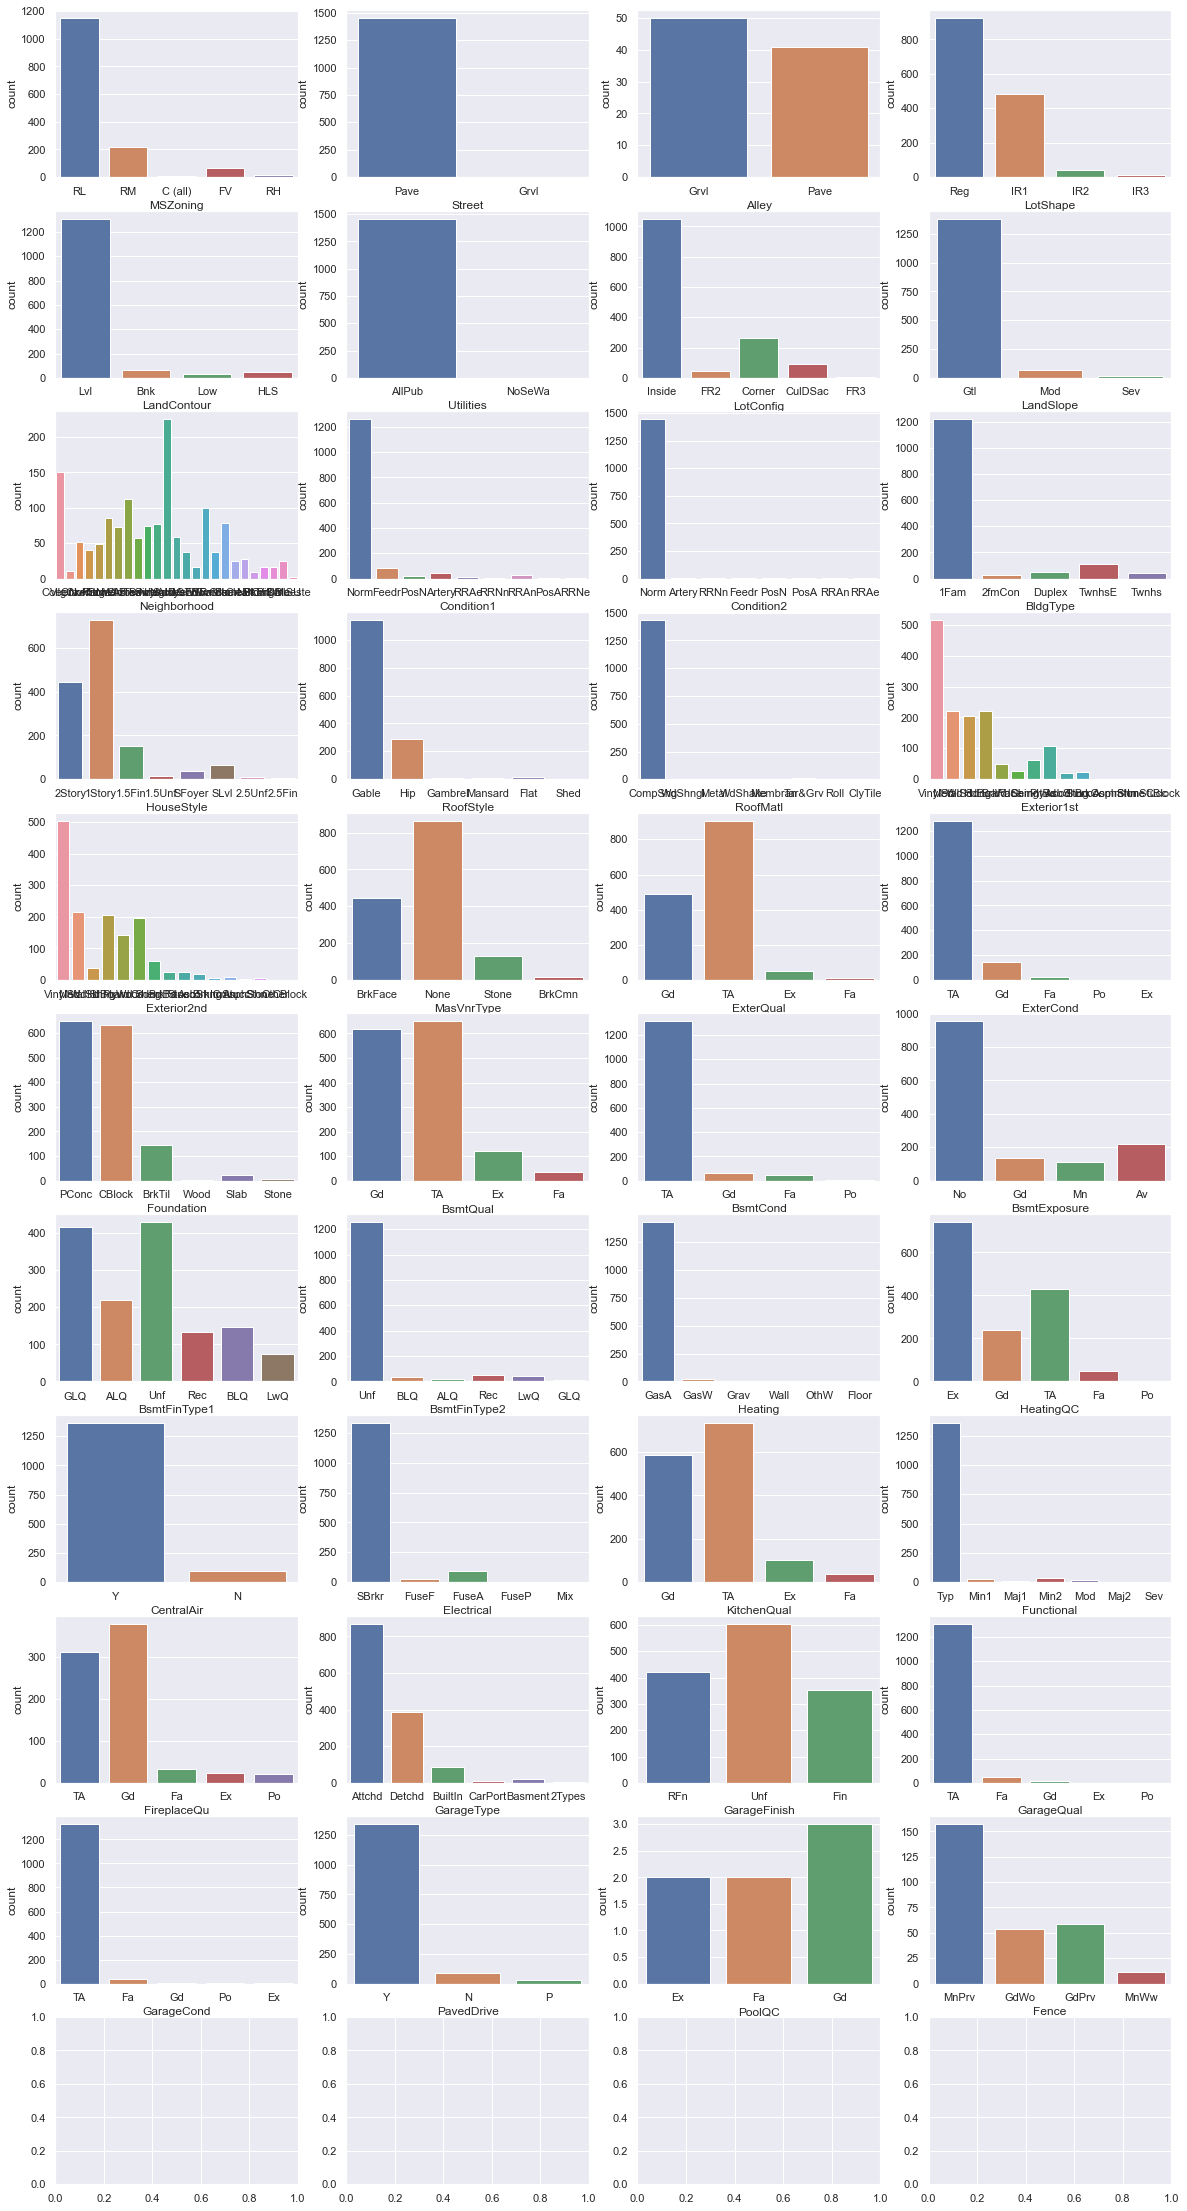

In [58]:
# Check Distribution of categorical variables.
fig, axes = plt.subplots(11, 4, figsize=(20, 40))

plot_cols = list(train_cat.columns)

for i in range(10):
    for j in range(4):
        sns.countplot(ax = axes[i, j], x = plot_cols[0], data = train_cat)
        plot_cols.pop(0)
        if plot_cols == []:
            break

In [59]:
cols_rm = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'Functional', 'GarageQual', 'GarageCond',
           'BsmtFinType2', 'CentralAir', 'Electrical']

# Remove them.
train_cat.drop(columns = cols_rm, axis = 'columns', inplace = True)
test_cat.drop(columns = cols_rm, axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
# Check shape
# Shape
print(f"Shape of train data (cat) : {train_cat.shape}\n")
print(f"Shape of test data (cat) : {test_cat.shape}\n")

Shape of train data (cat) : (1460, 32)

Shape of test data (cat) : (1459, 32)



In [64]:
# Check percentage of missing values.
def countNA(df, percent):
    cols = []
    values = []
    for col in df.columns:
        n = df[col].isna().sum() / len(df) * 100
        if n > percent:
            cols.append(col)
            values.append(n)
    d = {'Columns to be removed': cols, 'PercentNA': values}
    new_df = pd.DataFrame(d);
    return new_df

In [67]:
countNA(train_cat, 30)

,Columns to be removed,PercentNA
0,Alley,93.767123
1,FireplaceQu,47.260274
2,PoolQC,99.520548
3,Fence,80.753425
4,MiscFeature,96.301370


In [68]:
countNA(test_cat, 30)

,Columns to be removed,PercentNA
0,Alley,92.666210
1,FireplaceQu,50.034270
2,PoolQC,99.794380
3,Fence,80.123372
4,MiscFeature,96.504455


In [69]:
# Remove variables with more than 30% missing values.
train_cat.drop(columns = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 'columns', inplace = True)
test_cat.drop(columns = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [70]:
# Check shape
# Shape
print(f"Shape of train data (cat) : {train_cat.shape}\n")
print(f"Shape of test data (cat) : {test_cat.shape}\n")

Shape of train data (cat) : (1460, 27)

Shape of test data (cat) : (1459, 27)



##### Use chi-sq to remove co-dependent variables.
def chiSqSelector(df, alpha):
    col = df.shape[1]
    cols1 = []
    cols2 = []
    for i in range(col):
        for j in range(i+1, col):
            table = pd.crosstab(index = df[df.columns[i]], columns = df[df.columns[j]])
            stat, p, dof, expected = chi2_contingency(table)
            if p < alpha:
                cols1.append(df.columns[i])
                cols2.append(df.columns[j])
    return cols1, cols2

In [126]:
# Impute with mode missing values
train_cat_imputed = pd.DataFrame(imp_mode.fit_transform(train_cat))
train_cat_imputed.columns = train_cat.columns

test_cat_imputed = pd.DataFrame(imp_mode.fit_transform(test_cat))
test_cat_imputed.columns = test_cat.columns

In [131]:
train_cat = train_cat_imputed
test_cat = test_cat_imputed

In [132]:
train_cat.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [133]:
test_cat.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [134]:
# Separate nominal and ordinal variables.
nominal = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
           'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'PavedDrive', 
           'SaleType', 'SaleCondition', 'Foundation', 'GarageType']

ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
           'KitchenQual','GarageFinish']

train_cat_nom = train_cat[nominal]
test_cat_nom = test_cat[nominal]

train_cat_ord = train_cat[ordinal]
test_cat_ord = test_cat[ordinal]

In [141]:
# Use get dummies
cat_nom = pd.concat([train_cat_nom, test_cat_nom], axis = 'index')

cat_nom_dummies = pd.get_dummies(cat_nom)

In [144]:
cat_nom_dummies.shape

(2919, 139)

In [145]:
cat_nom_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [147]:
# split back into test and train sets
train_cat_nom = cat_nom_dummies.iloc[: 1460, :]
test_cat_nom = cat_nom_dummies.iloc[1460: , :]

In [151]:
# For ordinal, apply ordinal encoding

# ExterQual and ExterCond, BsmtQual and BsmtCond, KitchenQual, HeatingQC, GarageQual, GarageCond
general_dict = {'Po': 1, 'Fa': 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

train_cat_ord['ExterQual_ordinal'] = train_cat_ord['ExterQual'].map(general_dict)
train_cat_ord['ExterCond_ordinal'] = train_cat_ord['ExterCond'].map(general_dict)
train_cat_ord['BsmtQual_ordinal'] = train_cat_ord['BsmtQual'].map(general_dict)
train_cat_ord['BsmtCond_ordinal'] = train_cat_ord['BsmtCond'].map(general_dict)
train_cat_ord['KitchenQual_ordinal'] = train_cat_ord['KitchenQual'].map(general_dict)
train_cat_ord['HeatingQC_ordinal'] = train_cat_ord['HeatingQC'].map(general_dict)

# BsmtExposure
bsmtExposure_dict = {'No': 1, 'Mn': 2, 'Av' : 3, 'Gd': 4}
train_cat_ord['BsmtExposure_ordinal'] = train_cat_ord['BsmtExposure'].map(bsmtExposure_dict)

# BsmtFinType1
bsmtFinTypes_dict = {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
train_cat_ord['BsmtFinType1_ordinal'] = train_cat_ord['BsmtFinType1'].map(bsmtFinTypes_dict)

# GarageFinish
garageFinish_dict = {'Unf' : 1, 'RFn': 2, 'Fin' : 3}
train_cat_ord['garageFinish_ordinal'] = train_cat_ord['GarageFinish'].map(garageFinish_dict)

<ipython-input-151-c749a1dc1aa8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat_ord['ExterQual_ordinal'] = train_cat_ord['ExterQual'].map(general_dict)
<ipython-input-151-c749a1dc1aa8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat_ord['ExterCond_ordinal'] = train_cat_ord['ExterCond'].map(general_dict)
<ipython-input-151-c749a1dc1aa8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [152]:
# ExterQual and ExterCond, BsmtQual and BsmtCond, KitchenQual, HeatingQC, GarageQual, GarageCond
general_dict = {'Po': 1, 'Fa': 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

test_cat_ord['ExterQual_ordinal'] = test_cat_ord['ExterQual'].map(general_dict)
test_cat_ord['ExterCond_ordinal'] = test_cat_ord['ExterCond'].map(general_dict)
test_cat_ord['BsmtQual_ordinal'] = test_cat_ord['BsmtQual'].map(general_dict)
test_cat_ord['BsmtCond_ordinal'] = test_cat_ord['BsmtCond'].map(general_dict)
test_cat_ord['KitchenQual_ordinal'] = test_cat_ord['KitchenQual'].map(general_dict)
test_cat_ord['HeatingQC_ordinal'] = test_cat_ord['HeatingQC'].map(general_dict)

# BsmtExposure
bsmtExposure_dict = {'No': 1, 'Mn': 2, 'Av' : 3, 'Gd': 4}
test_cat_ord['BsmtExposure_ordinal'] = test_cat_ord['BsmtExposure'].map(bsmtExposure_dict)

# BsmtFinType1
bsmtFinTypes_dict = {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
test_cat_ord['BsmtFinType1_ordinal'] = test_cat_ord['BsmtFinType1'].map(bsmtFinTypes_dict)

# GarageFinish
garageFinish_dict = {'Unf' : 1, 'RFn': 2, 'Fin' : 3}
test_cat_ord['garageFinish_ordinal'] = test_cat_ord['GarageFinish'].map(garageFinish_dict)

<ipython-input-152-6def7a2df785>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cat_ord['ExterQual_ordinal'] = test_cat_ord['ExterQual'].map(general_dict)
<ipython-input-152-6def7a2df785>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cat_ord['ExterCond_ordinal'] = test_cat_ord['ExterCond'].map(general_dict)
<ipython-input-152-6def7a2df785>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [155]:
# Remove redundant columns in train and test sets
train_cat_ord.drop(columns = ordinal, axis = 'columns', inplace = True)
test_cat_ord.drop(columns = ordinal, axis = 'columns', inplace = True)

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [160]:
test_cat_ord.shape

(1459, 9)

In [161]:
# Consolidate all the categorical variables together
train_cat = pd.concat([train_cat_nom, train_cat_ord], axis = 'columns')

test_cat = pd.concat([test_cat_nom, test_cat_ord], axis = 'columns')

In [168]:
# Check shape
# Shape
print(f"Shape of train data (cat) : {train_cat.shape}\n")
print(f"Shape of test data (cat) : {test_cat.shape}\n")

Shape of train data (cat) : (1460, 148)

Shape of test data (cat) : (1459, 148)



# Preparing data for model fitting

In [166]:
# Add numerical columns and categorical columns tgt
train_cleaned = pd.concat([train_cat, train_num], axis = 'columns')
test_cleaned = pd.concat([test_cat, test_num], axis = 'columns')

In [167]:
# Check shape
# Shape
print(f"Shape of train data (cleaned) : {train_cleaned.shape}\n")
print(f"Shape of test data (cleaned) : {test_cleaned.shape}\n")

Shape of train data (cleaned) : (1460, 162)

Shape of test data (cleaned) : (1459, 161)



In [172]:
X = train_cleaned.copy().drop(["SalePrice"], axis = 1)
y = train.loc[:, 'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Model - Linear Regression

In [173]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print(model_lr.score(X_train, y_train))

print(model_lr.score(X_test, y_test))

predictions=model_lr.predict(X_test)

0.8891730992274376
0.7614962046572781


In [176]:
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error(MSE):', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
print('Explained Variance Score (EVS):',explained_variance_score(y_test,predictions))
print('R2:',r2_score(y_test, predictions))

Mean Absolute Error(MAE): 21796.796266320634
Mean Squared Error(MSE): 1878939294.8745432
Root Mean Squared Error (RMSE): 43346.73338181948
Explained Variance Score (EVS): 0.7615566582776591
R2: 0.7614962046572781


# Model - Ridge

In [197]:
model_ridge = Ridge(alpha = 0.001)
model_ridge.fit(X_train, y_train)

print(model_ridge.score(X_train,y_train))
print(model_ridge.score(X_test, y_test))

predictions=model_ridge.predict(X_test)

0.8891731342718107
0.7615360317582781


In [198]:
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error(MSE):', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
print('Explained Variance Score (EVS):',explained_variance_score(y_test,predictions))
print('R2:',r2_score(y_test, predictions))

Mean Absolute Error(MAE): 21794.451788770984
Mean Squared Error(MSE): 1878625535.904954
Root Mean Squared Error (RMSE): 43343.11405407962
Explained Variance Score (EVS): 0.76159632401369
R2: 0.7615360317582781


# Model - Random Forest Regressor

In [199]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [183]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, 
                               cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [184]:
best_random = rf_random.best_estimator_

In [185]:
best_random.score(X_train, y_train)

0.988940981868806

In [186]:
best_random.score(X_test, y_test)

0.8459917909858811

In [187]:
predictions=best_random.predict(X_test)

In [188]:
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error(MSE):', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
print('Explained Variance Score (EVS):',explained_variance_score(y_test,predictions))
print('R2:',r2_score(y_test, predictions))

Mean Absolute Error(MAE): 19743.038142123292
Mean Squared Error(MSE): 1213280800.1401484
Root Mean Squared Error (RMSE): 34832.180525200376
Explained Variance Score (EVS): 0.8460535603586494
R2: 0.8459917909858811


In [203]:
model_las = Lasso(alpha =  0.001)
model_ridge.fit(X_train, y_train)

print(model_ridge.score(X_train,y_train))
print(model_ridge.score(X_test, y_test))

predictions=model_ridge.predict(X_test)

0.8891731342718107
0.7615360317582781


In [201]:
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error(MSE):', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
print('Explained Variance Score (EVS):',explained_variance_score(y_test,predictions))
print('R2:',r2_score(y_test, predictions))

Mean Absolute Error(MAE): 21794.451788770984
Mean Squared Error(MSE): 1878625535.904954
Root Mean Squared Error (RMSE): 43343.11405407962
Explained Variance Score (EVS): 0.76159632401369
R2: 0.7615360317582781


In [205]:
# Define hyperparameters
alphas = np.logspace(-3, 3, 100).tolist()

tuned_paras = {"alpha": alphas}

# GridSearch
lasso_cv = GridSearchCV(Lasso(), tuned_paras, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
lasso_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lasso_cv.best_params_}")
print(f"Best R² (train): {lasso_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 123.28467394420659}
Best R² (train): 0.8451821647897777


In [ ]:
best_lasso = Lasso(alpha = lasso_cv.best_params_["alpha"])

best_lasso.fit(X_train, y_train)
predictions = best_lasso.predict(X_test)
print('R2:',r2_score(y_test, predictions))

# Evaluation - Use LASSO

In [208]:
# Prediction of House Prices using the Optimal Lasso Regression Model

y_pred = best_lasso.predict(test_cleaned)

output = pd.DataFrame({"Id": test_id,
                       "SalePrice": y_pred})

In [210]:
output.to_csv("submission.csv", index=False)